# Importing Libraries

In [ ]:
import math
import sys
from collections import namedtuple
import pandas as pd
from plotnine import ggplot, aes, geom_polygon, geom_segment, geom_point

## The Algorithm

In [ ]:
Vertex = namedtuple('Vertex', ['x', 'y'])
EPSILON = math.sqrt(sys.float_info.epsilon)


def earclip(polygon):                   # Algorithm to triangulate
    ear_vertex = []
    triangles = []

    polygon = [Vertex(*vertex) for vertex in polygon]

    if isCw(polygon):          # To check if the triangulation is clockwise
        polygon.reverse()

    count_vert = len(polygon)
    for i in range(count_vert):
        prev_index = i - 1
        prev_vertex = polygon[prev_index]
        vertex = polygon[i]
        next_index = (i + 1) % count_vert
        next_vertex = polygon[next_index]

        if is_ear(prev_vertex, vertex, next_vertex, polygon):
            ear_vertex.append(vertex)

    while ear_vertex and count_vert >= 3:
        ear = ear_vertex.pop(0)
        i = polygon.index(ear)
        prev_index = i - 1
        prev_vertex = polygon[prev_index]
        next_index = (i + 1) % count_vert
        next_vertex = polygon[next_index]

        polygon.remove(ear)
        count_vert -= 1
        triangles.append(((prev_vertex.x, prev_vertex.y), (ear.x, ear.y), (next_vertex.x, next_vertex.y)))
        if count_vert > 3:
            prev_prev_vertex = polygon[prev_index - 1]
            next_next_index = (i + 1) % count_vert
            next_next_vertex = polygon[next_next_index]

            groups = [
                (prev_prev_vertex, prev_vertex, next_vertex, polygon),
                (prev_vertex, next_vertex, next_next_vertex, polygon),
            ]
            for group in groups:
                p = group[1]
                if is_ear(*group):
                    if p not in ear_vertex:
                        ear_vertex.append(p)
                elif p in ear_vertex:
                    ear_vertex.remove(p)
    return triangles


def isCw(polygon):                 # definition of function to check direction of triangulation
    s = 0
    polygon_count = len(polygon)
    for i in range(polygon_count):
        vertex = polygon[i]
        vertex2 = polygon[(i + 1) % polygon_count]
        s += (vertex2.x - vertex.x) * (vertex2.y + vertex.y)
    return s > 0


def is_convex(prev, vertex, next):        
    return triang_sum(prev.x, prev.y, vertex.x, vertex.y, next.x, next.y) < 0


def is_ear(p1, p2, p3, polygon):
    ear = no_int_vert(p1, p2, p3, polygon) and \
        is_convex(p1, p2, p3) and \
        triang_area(p1.x, p1.y, p2.x, p2.y, p3.x, p3.y) > 0
    return ear


def no_int_vert(p1, p2, p3, polygon):
    for pn in polygon:
        if pn in (p1, p2, p3):
            continue
        elif is_int_vert(pn, p1, p2, p3):
            return False
    return True


def is_int_vert(p, a, b, c):
    area = triang_area(a.x, a.y, b.x, b.y, c.x, c.y)
    area1 = triang_area(p.x, p.y, b.x, b.y, c.x, c.y)
    area2 = triang_area(p.x, p.y, a.x, a.y, c.x, c.y)
    area3 = triang_area(p.x, p.y, a.x, a.y, b.x, b.y)
    areadiff = abs(area - sum([area1, area2, area3])) < EPSILON
    return areadiff


def triang_area(x1, y1, x2, y2, x3, y3):
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)


def triang_sum(x1, y1, x2, y2, x3, y3):
    return x1 * (y3 - y2) + x2 * (y1 - y3) + x3 * (y2 - y1)


def heron_area(triangles):
    result = []
    for triangle in triangles:
        sides = []
        for i in range(3):
            next_index = (i + 1) % 3
            pt = triangle[i]
            pt2 = triangle[next_index]
            # Distance between two points
            side = math.sqrt(math.pow(pt2[0] - pt[0], 2) + math.pow(pt2[1] - pt[1], 2))
            sides.append(side)
        c, b, a = sorted(sides)
        area = .25 * math.sqrt(abs((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c))))
        result.append((area, a, b, c))
    triangle_area = sum(tri[0] for tri in result)
    return triangle_area

# Function Call

In [ ]:
def wire_frame_pol(polygon):
        x = [i[0] for i in polygon]
        y = [i[1] for i in polygon]
        df = pd.DataFrame({'x': x, 'y': y})
        return df
    
def wire_frame_triang(triangles):
    x_start = []
    x_end = []
    y_start = []
    y_end = []
    for triangle in triangles:
        for i, pt in enumerate(triangle):
            next_index = (i + 1) % 3
            x_start.append(pt[0])
            x_end.append(triangle[next_index][0])
            y_start.append(pt[1])
            y_end.append(triangle[next_index][1])
    df = pd.DataFrame({'x': x_start, 'y': y_start, 'xend': x_end, 'yend': y_end})
    return df

# Framing the Polygon

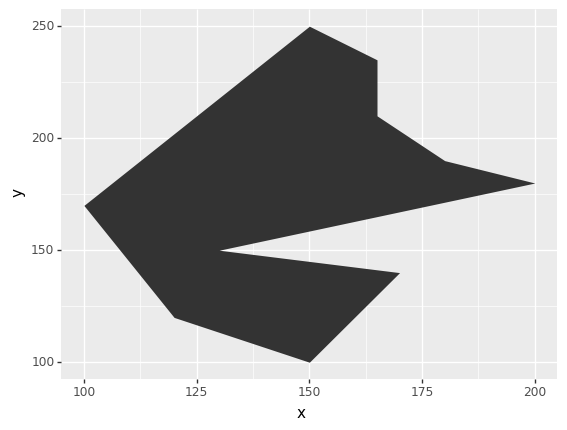

<ggplot: (8772811753353)>

In [ ]:
rand_poly = [(200, 180), (180, 190), (165, 210), (165, 235), (150, 250), (100, 170), (120, 120), (150, 100), (170, 140), (130, 150)]
df = wire_frame_pol(rand_poly)
(ggplot(df, aes(x='x', y='y')) + geom_polygon())

# Triangulated Polygon

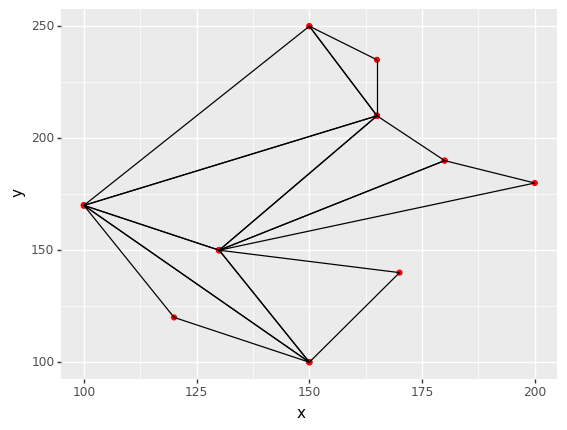

<ggplot: (8772811768061)>

In [ ]:
triangles = earclip(rand_poly)
df = wire_frame_triang(triangles)
(ggplot(df, aes(x='x', y='y')) + geom_point(color='red') + geom_segment(aes(x='x', y='y', xend='xend', yend='yend')))